In [11]:
#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz
#!pip install seaborn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [8]:
def wavelet(t,c,a,b,d,scale,repeat):
    """generate synthetic time waves according to epsilon+ (x-c)*sin(ax+b)"""
    twaves = np.repeat((np.arange(t)/t).reshape(1,-1),repeat,axis=0)
    epsilon = np.random.normal(loc=0.0,scale=scale,size=(repeat,t))
    return (d*twaves-c)*np.sin(a*np.arange(t)+b) + epsilon

def garch(a,b,w,t,normalize=True):
    epsilon_s = np.random.normal(loc=0.0,scale=1,size=1)
    x_s = [epsilon_s * np.sqrt(w)]
    epsilon_s = [epsilon_s]
    for i in range(t-1):
        epsilon_t = np.random.normal(loc=0.0, scale = 1, size = 1)
        x_t_minus_1 = x_s[-1]
        epsilon_t_minus_1 = epsilon_s[-1]
        sigma_t = np.sqrt(w + a * x_t_minus_1**2 + b* (epsilon_t_minus_1**2))
        x_t = sigma_t * epsilon_t
        x_s.append(x_t)
        epsilon_s.append(epsilon_t)
        arr = np.array(x_s)
    if normalize:
        arr = 2* (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) -1
    return arr

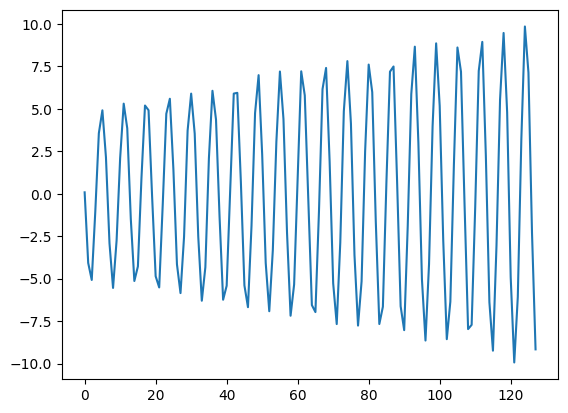

In [30]:
plt.plot(wavelet(t=128,c=-5,a=-1,b=0.120,d=5,scale=0.2,repeat=1).reshape(128,-1))

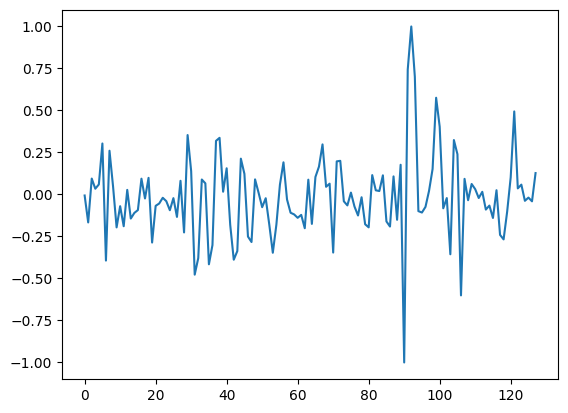

In [40]:
plt.plot(garch(t=128,a=1,b=1,w=0.5).reshape(128,-1))

In [38]:
from jax import random
import numpyro
from numpyro.contrib.control_flow import scan
import jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
assert numpyro.__version__.startswith("0.15.2")

In [36]:
#wavelet model 
def wavelet_model(t,obs=None):
    a = numpyro.sample("a", dist.Uniform(-1.0, 1.0))
    b = numpyro.sample("b", dist.Uniform(-1.0,1.0))
    c = numpyro.sample("c", dist.Uniform(0.0, 5.0))
    d = numpyro.sample("d", dist.Uniform(0.0,5.0))
    twaves = jax.numpy.arange(t)/t
    wavelet = (d * twaves - c)*jax.numpy.sin(a * twaves + b)
    return numpyro.sample("obs", dist.Normal(wavelet,0.3), obs=obs)
     

In [37]:
nuts_kernel = NUTS(wavelet_model)
mcmc = MCMC(nuts_kernel, num_samples=1, num_warmup=0)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t=128, obs=None)

sample: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it, 1 steps of size 1.00e+00. acc. prob=0.00]


In [41]:
def garch_model(t, obs=None):
    a = numpyro.sample("a", dist.Uniform(0, 1)) 
    b = numpyro.sample("b", dist.Uniform(0, 1))
    w = numpyro.sample("w", dist.Uniform(0, 1))
    epsilon_0 = numpyro.sample("epsilon_0", dist.Normal(0.0, 1.0))
    sigma_0 = jax.numpy.sqrt(w)
    x_0 = numpyro.sample("x_0", dist.Normal(0.0, sigma_0), obs=obs[0] if obs is not None else None)
    def garch_step(state, i):
        x_prev, epsilon_prev = state
        sigma_t = jax.numpy.sqrt(w + a * x_prev**2 + b * epsilon_prev**2)
        epsilon_t = numpyro.sample(f"epsilon_{i}", dist.Normal(0.0, 1.0))
        x_t = numpyro.sample(f"x_{i}", dist.Normal(0.0, sigma_t), obs=obs[i] if obs is not None else None)
        return (x_t, epsilon_t), x_t
    _, x_s = scan(garch_step, (x_0, epsilon_0), jax.numpy.arange(1, t))
    return x_s

In [42]:
nuts_kernel = NUTS(garch_model)
mcmc = MCMC(nuts_kernel, num_samples=1, num_warmup=0)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t=128, obs=None)


KeyboardInterrupt



In [43]:
def mixed_model(t, x_obs=None):
    model_choice = numpyro.sample("model_choice", dist.Bernoulli(0.5))
    if model_choice == 0:
        return garch_model(t=t, x_obs=x_obs)
    else:
        return wavelet_model(t, obs=x_obs)